# Slow code 

In [65]:
"""
Created on Sat Sep 18 10:19:34 2021
@author: Valen
"""

import sys
from environment import Environment
from demo_controller import player_controller

# imports other libs
import time
import numpy as np
#from math import fabs,sqrt
import os
# DEAP - own code starts here 
from deap import base, creator
import random
from deap import tools
from array import array


sys.path.insert(0, 'evoman')
# choose this for not using visuals and thus making experiments faster
headless = True
if headless:
    os.environ["SDL_VIDEODRIVER"] = "dummy"


experiment_name = 'individual_demo'
if not os.path.exists(experiment_name):
    os.makedirs(experiment_name)

n_hidden_neurons = 10

# initializes simulation in individual evolution mode, for single static enemy.
env = Environment(experiment_name=experiment_name,
                  enemies=[2],
                  playermode="ai",
                  player_controller=player_controller(n_hidden_neurons),
                  enemymode="static",
                  level=2,
                  speed="fastest")

# default environment fitness is assumed for experiment

env.state_to_log() # checks environment state


####   Optimization for controller solution (best genotype-weights for phenotype-network): Ganetic Algorihm    ###

ini = time.time()  # sets time marker


# genetic algorithm params

run_mode = 'train' # train or test

# number of weights for multilayer with 10 hidden neurons
n_vars = (env.get_num_sensors()+1)*n_hidden_neurons + (n_hidden_neurons+1)*5
print("Number of weights: " + str(n_vars))


# runs simulation
def simulation(env,x):
    f,p,e,t = env.play(pcont=x)
    return f

# evaluation
def evaluate(x):
    return np.array(list(map(lambda y: simulation(env,y), x)))


#maximizing fitness
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
#creator.create("Individual", list, fitness=creator.FitnessMax)
creator.create("Individual", array, typecode="d",
               fitness=creator.FitnessMax, strategy=None)
creator.create("Strategy", array, typecode="d")

def initES(icls, scls, size, imin, imax, smin, smax):
    ind = icls(random.uniform(imin, imax) for _ in range(size))
    ind.strategy = scls(random.uniform(smin, smax) for _ in range(size))
    return ind

IND_SIZE = n_vars
MIN_VALUE, MAX_VALUE = -1., 1.
MIN_STRAT, MAX_STRAT = -1., 1. 

toolbox = base.Toolbox()
toolbox.register("individual", initES, creator.Individual,
                 creator.Strategy, IND_SIZE, MIN_VALUE, MAX_VALUE, MIN_STRAT, 
                 MAX_STRAT)


#uniform = random.uniform(-1, 1)
toolbox.register("attribute", np.random.uniform, -1, 1)
#random.uniform(-1.,1.)
#toolbox.register("individual", tools.initRepeat, creator.Individual,
#                 toolbox.attribute, n= n_vars)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
#toolbox.register("population", tools.initRepeat, np.array([]), toolbox.individual)



toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutESLogNormal, c = 1, indpb=0.1)
toolbox.register("parentselection", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)
toolbox.register("survivalselection", tools.selBest)

#to compile statistics
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)
logbook = tools.Logbook()


pop_size = 20

#test

def main():
    # create variables to later save the best individual
    best_ind = 1
    best_fit = -100
    
    
    pop = toolbox.population(n=pop_size)
    CXPB, MUTPB, NGEN = 0.7, 0.2, 10

    # Evaluate the entire population
    for i in range(len(pop)):
        fitness = toolbox.evaluate(np.array([pop[i]]))
        pop[i].fitness.values = fitness
        if fitness > best_fit:
            best_fit = fitness
            best_ind = pop[i]

    # show first random generation
    record = stats.compile(pop)
    print("Gen 0: ")
    print(record)
    

    for g in range(NGEN):
        # Select the next generation individuals - parent selection 
        parents = toolbox.parentselection(pop, (2*len(pop)))
        # Clone the selected individuals
        parents = list(map(toolbox.clone, parents))

        
        offspring = []
        # Apply crossover on the offspring
        for parent1, parent2 in zip(parents[::2], parents[1::2]): 
            if random.random() < CXPB:
                child1, child2 = toolbox.mate(parent1, parent2)
                del child1.fitness.values
                del child2.fitness.values
                offspring.append(child1)
                offspring.append(child2)
        print(len(offspring)) 
        
        #or like this
# =============================================================================
#         for child1, child2 in zip(parents[::2], parents[1::2]):
#             if random.random() < CXPB:
#                 toolbox.mate(child1, child2)
#                 del child1.fitness.values
#                 del child2.fitness.values
# =============================================================================
                
        # mutation
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        #invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        #for i in range(len(invalid_ind)):
        #    invalid_ind[i].fitness.values = toolbox.evaluate(np.array([invalid_ind[i]]))
        for i in range(len(offspring)):
            fitness = toolbox.evaluate(np.array([offspring[i]]))
            offspring[i].fitness.values = fitness
            if fitness > best_fit:
                best_fit = fitness
                best_ind = offspring[i]
                
        #fitnesses = map(toolbox.evaluate, np.array(offspring).reshape(1, len(offspring), n_vars))
        #for ind, fit in zip(offspring, fitnesses):
        #    ind.fitness.values = fit
        #    if max(fit) > best_fit:
        #        best_fit = max(fit)
        #        best_ind = pop[np.where(fit == max(fit))[0][0]]
            
        
        survivedoffspring = toolbox.survivalselection(offspring, pop_size)
        
        # The population is entirely replaced by the offspring
        pop = survivedoffspring
        print(len(pop))
        
        record = stats.compile(pop)
        print("Gen : " + str(g+1))
        print(record)
        logbook.record(gen= (g +1), evals=30, **record)
        
    return best_ind



MESSAGE: Pygame initialized for simulation.

########## Simulation state - INI ###########

# solutions # : EMPTY 

# sensors # : 20

 ------  parameters ------  

# contact hurt (training agent) # : player

multiple mode: no

enemies list: 2

current enemy: 2

player mode: ai

enemy mode: static

level: 2

clock precision: low

inputs coded: no

random initialization: yes

expiration time: 3000

speed: fastest

load player: yes

load enemy: yes

sound: off

overture time: 100

logs: on

save logs: yes

########## Simulation state - END ###########
Number of weights: 265


# Fast Code

## Two point cross-over

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 18 10:19:34 2021
@author: Valen
"""

import sys
sys.path.insert(0, 'evoman')
from environment import Environment
from demo_controller import player_controller

# imports other libs
import time
import numpy as np
#from math import fabs,sqrt
import os
from multiprocess import Pool
import psutil
import statistics
# DEAP - own code starts here 
from deap import base, creator
import random
from deap import tools
from array import array
import matplotlib.pyplot as plt



num_cpus = psutil.cpu_count(logical=False)
pool = Pool(num_cpus)

# choose this for not using visuals and thus making experiments faster
headless = True
if headless:
    os.environ["SDL_VIDEODRIVER"] = "dummy"


experiment_name = 'individual_demo'
if not os.path.exists(experiment_name):
    os.makedirs(experiment_name)

n_hidden_neurons = 10

# initializes simulation in individual evolution mode, for single static enemy.
# env = Environment(experiment_name=experiment_name,
#               enemies=[1],
#               playermode="ai",
#               player_controller=player_controller(n_hidden_neurons),
#               enemymode="static",
#               level=2,
#               speed="fastest")

# default environment fitness is assumed for experiment

# env.state_to_log() # checks environment state


####   Optimization for controller solution (best genotype-weights for phenotype-network): Ganetic Algorihm    ###

ini = time.time()  # sets time marker


# genetic algorithm params

run_mode = 'train' # train or test

# number of weights for multilayer with 10 hidden neurons
# n_vars = (env.get_num_sensors()+1)*n_hidden_neurons + (n_hidden_neurons+1)*5
n_vars = 265
print("Number of weights: " + str(n_vars))


# runs simulation
def simulation(x, enemies, player_controller = player_controller, Environment = Environment):
    #unconventional, but necessary to run code on multiple cores to speed up processing 
    n_hidden_neurons = 10
    experiment_name = 'individual_demo'
    env = Environment(experiment_name=experiment_name,
                  enemies=enemies,
                  playermode="ai",
                  player_controller=player_controller(n_hidden_neurons),
                  enemymode="static",
                  level=2,
                  speed="fastest")
    
    f,p,e,t = env.play(pcont=x)
    return f


#maximizing fitness
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
#creator.create("Individual", list, fitness=creator.FitnessMax)
creator.create("Individual", array, typecode="d",
               fitness=creator.FitnessMax, strategy=None)
creator.create("Strategy", array, typecode="d")

def initES(icls, scls, size, imin, imax, smin, smax):
    ind = icls(random.uniform(imin, imax) for _ in range(size))
    ind.strategy = scls(random.uniform(smin, smax) for _ in range(size))
    return ind

IND_SIZE = n_vars # number of weights of the neural network that we will optimize
MIN_VALUE, MAX_VALUE = -1., 1. # Minimum and maximum values of the weights are -1 and 1, respectively
MIN_STRAT, MAX_STRAT = -1., 1. 


# register tools
toolbox = base.Toolbox()
toolbox.register("individual", initES, creator.Individual,
                 creator.Strategy, IND_SIZE, MIN_VALUE, MAX_VALUE, MIN_STRAT, 
                 MAX_STRAT)
toolbox.register("attribute", np.random.uniform, -1, 1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# toolbox.register("evaluate", simulation)
toolbox.register("survivalselection", tools.selBest)

#to compile statistics
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)
#Make two logbooks for the different experiments
logbook_tc_2 = tools.Logbook()
logbook_tc_5 = tools.Logbook()
logbook_tc_7 = tools.Logbook()

logbook_bc_2 = tools.Logbook()
logbook_bc_5 = tools.Logbook()
logbook_bc_7 = tools.Logbook()


#test

def twopointcx(CXPB, offsprMUTPB, allelmutpb, tournsize, enemies, logbook):
    # create variables to later save the best individual
    best_ind = 1
    best_fit = -100
    
    toolbox.register("mate", tools.cxESTwoPoint)
    toolbox.register("mutate", tools.mutESLogNormal, c = 1, indpb= allelmutpb)
    toolbox.register("parentselection", tools.selTournament, tournsize=tournsize)
    pop = toolbox.population(n=pop_size)
    toolbox.register("evaluate", simulation, enemies=enemies)
    

    
    if __name__ == '__main__':
    #multiprocessing.set_start_method('fork')
        fitnesses = list(pool.map(toolbox.evaluate, np.array(pop)))
    for i in range(len(pop)):
        pop[i].fitness.values = (fitnesses[i],)
        if fitnesses[i] > best_fit:
            best_fit = fitnesses[i]
            best_ind = pop[i]
            
    # show first random generation
    record = stats.compile(pop)

    for g in range(NGEN):
        # Select the next generation individuals - parent selection 
        parents = toolbox.parentselection(pop, (2*len(pop)))
        # Clone the selected individuals
        parents = list(map(toolbox.clone, parents))

        offspring = []
        # Apply crossover on the offspring
        for parent1, parent2 in zip(parents[::2], parents[1::2]): 
            if random.random() < CXPB:
                child1, child2 = toolbox.mate(parent1, parent2)
                del child1.fitness.values
                del child2.fitness.values
                offspring.append(child1)
                offspring.append(child2)
               
        # mutation
        for mutant in offspring:
            if random.random() < offsprMUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
                
        if __name__ == '__main__':
            fitnesses = list(pool.map(toolbox.evaluate, np.array(offspring)))
        for i in range(len(offspring)):
            offspring[i].fitness.values = (fitnesses[i],)
            if fitnesses[i] > best_fit:
                best_fit = fitnesses[i]
                best_ind = offspring[i]
        
        survivedoffspring = toolbox.survivalselection(offspring, pop_size)
        
        # The population is entirely replaced by the offspring
        pop = survivedoffspring
        
        #Get statistics and save them to the logbook
        record = stats.compile(pop)
        logbook.record(gen= (g +1), evals=30, **record)
        
    return best_ind, best_fit


pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html
Number of weights: 265


## Blend Crossover 

In [2]:
def blendcx(CXPB, offsprMUTPB, allelmutpb, tournsize, enemies, logbook):
    # create variables to later save the best individual
    best_ind = 1
    best_fit = -100

    toolbox.register("mate", tools.cxESBlend, alpha = 0.5)
    toolbox.register("mutate", tools.mutESLogNormal, c = 1, indpb= allelmutpb)
    toolbox.register("parentselection", tools.selTournament, tournsize=tournsize)
    pop = toolbox.population(n=pop_size)
    toolbox.register("evaluate", simulation, enemies=enemies)

    if __name__ == '__main__':
    #multiprocessing.set_start_method('fork')
        fitnesses = list(pool.map(toolbox.evaluate, np.array(pop)))
    for i in range(len(pop)):
        pop[i].fitness.values = (fitnesses[i],)
        if fitnesses[i] > best_fit:
            best_fit = fitnesses[i]
            best_ind = pop[i]
            
    # show first random generation
    record = stats.compile(pop)
    #print("Gen 0: ")
    #print(record)
    

    for g in range(NGEN):
        # Select the next generation individuals - parent selection 
        parents = toolbox.parentselection(pop, (2*len(pop)))
        # Clone the selected individuals
        parents = list(map(toolbox.clone, parents))

        
        offspring = []
        # Apply crossover on the offspring
        
        #like this
        for parent1, parent2 in zip(parents[::2], parents[1::2]): 
            if random.random() < CXPB:
                child1, child2 = toolbox.mate(parent1, parent2) #Set alpha to 0.5 for now
                del child1.fitness.values
                del child2.fitness.values
                offspring.append(child1)
                offspring.append(child2)
             
        for mutant in offspring:
            if random.random() < offsprMUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

  
        if __name__ == '__main__':
            fitnesses = list(pool.map(toolbox.evaluate, np.array(offspring)))
        for i in range(len(offspring)):
            offspring[i].fitness.values = (fitnesses[i],)
            if fitnesses[i] > best_fit:
                best_fit = fitnesses[i]
                best_ind = offspring[i]
        
        survivedoffspring = toolbox.survivalselection(offspring, pop_size)
        
        # The population is entirely replaced by the offspring
        pop = survivedoffspring
        
        record = stats.compile(pop)
        logbook.record(gen= (g +1), evals=30, **record)
        
    return best_ind, best_fit

# Parameter optimization 

In [3]:
#Parameter optimization using Gridsearch
# for a two-point crossover
pop_size = 100
NGEN = 10

best_cxpb = 0
best_offsprmutpb = 0
best_mean = 1
best_tournsize = 0

    
for cxpb in [0.7, 0.85, 1]:
    for offsprmutpb in [0.1, 0.2, 0.3]:
        for allelmutpb in [0.1, 0.2, 0.3]:
            for tournsize in [2, 3, 4]:
                print("Offspring Mutation Probability: " + str(offsprmutpb))
                print("Allele Mutation Probability: " + str(allelmutpb))
                print("Crossover Probability: " + str(cxpb))
                print("Tournament Size: " + str(tournsize))
                best_individuals = []
                best_scores = []
                for i in range(5):
                    best_ind, best_score = twopointcx(cxpb, offsprmutpb, allelmutpb, tournsize)
                    best_individuals.append(best_ind)
                    best_scores.append(best_score)
                print(np.mean(best_scores))
                print()
                if np.mean(best_scores) > best_mean:
                    best_mean = np.mean(best_scores)
                    best_cxpb = cxpb
                    best_offsprmutpb = offsprmutpb
                    best_allelmutpb = allelmutpb
                    best_tournsize = tournsize
            
print("Best results: ")
print("Best Crossover Probability: " + str(best_cxpb))
print("Best Offspring Mutation Probability: " + str(best_offsprmutpb))
print("Best allele Mutation Probability: " + str(best_allelmutpb))
print("Best tournament size: " + str(best_tournsize))
print(best_mean)

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.1
Crossover Probability: 0.7
Tournament Size: 2
66.53969812413108

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.1
Crossover Probability: 0.7
Tournament Size: 3
80.84198857579531

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.1
Crossover Probability: 0.7
Tournament Size: 4
82.79414710221617

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.2
Crossover Probability: 0.7
Tournament Size: 2
77.2579311603135

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.2
Crossover Probability: 0.7
Tournament Size: 3
73.6148763154129

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.2
Crossover Probability: 0.7
Tournament Size: 4
71.96904137437359

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.3
Crossover Probability: 0.7
Tournament Size: 2
68.01754394324428

Offspring Mutation Probability: 0.1
Allele Mutation Probability:

KeyboardInterrupt: 

results first gridsearch
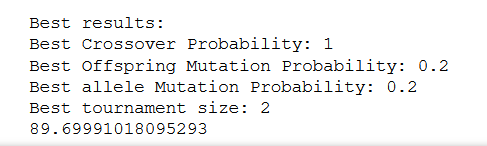

In [6]:
# for blend cx

pop_size = 100
NGEN = 10

best_cxpb = 0
best_offsprmutpb = 0
best_mean = 1
best_tournsize = 0

    
for cxpb in [0.7, 0.85, 1]:
    for offsprmutpb in [0.1, 0.2, 0.3]:
        for allelmutpb in [0.1, 0.2, 0.3]:
            for tournsize in [2, 3, 4]:
                print("Offspring Mutation Probability: " + str(offsprmutpb))
                print("Allele Mutation Probability: " + str(allelmutpb))
                print("Crossover Probability: " + str(cxpb))
                print("Tournament Size: " + str(tournsize))
                best_individuals = []
                best_scores = []
                for i in range(5):
                    best_ind, best_score = blendcx(cxpb, offsprmutpb, allelmutpb, tournsize)
                    best_individuals.append(best_ind)
                    best_scores.append(best_score)
                print(np.mean(best_scores))
                print()
                if np.mean(best_scores) > best_mean:
                    best_mean = np.mean(best_scores)
                    best_cxpb = cxpb
                    best_offsprmutpb = offsprmutpb
                    best_allelmutpb = allelmutpb
                    best_tournsize = tournsize
            
print("Best results: ")
print("Best Crossover Probability: " + str(best_cxpb))
print("Best Offspring Mutation Probability: " + str(best_offsprmutpb))
print("Best allele Mutation Probability: " + str(best_allelmutpb))
print("Best tournament size: " + str(best_tournsize))
print(best_mean)

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.1
Crossover Probability: 0.7
Tournament Size: 2


TypeError: blendcx() missing 2 required positional arguments: 'enemies' and 'logbook'

# Experimental runs

#### Fast code

In [4]:
pop_size = 10
NGEN = 10
runs = 1

In [3]:
t0 = time.time()

best_individuals_tc_2 = []
best_scores_tc_2 = []
for i in range(runs):
    best_ind_tc_2, best_score_tc_2 = twopointcx(1, 0.2, 0.1, 2, [2], logbook_tc_2) #tournament size was not set
    best_individuals_tc_2.append(best_ind_tc_2)
    best_scores_tc_2.append(best_score_tc_2)
    
print(logbook_tc_2)
print(best_scores_tc_2)

t1 = time.time()

total = t1-t0
total

avg          	evals	gen	max          	min          	std          
[9.73533805] 	30   	1  	[57.21617482]	[-5.77144112]	[23.69229228]
[21.52852215]	30   	2  	[57.19486503]	[-5.05624581]	[26.97175426]
[46.40589245]	30   	3  	[66.231679]  	[30.18586947]	[11.94888074]
[67.96549758]	30   	4  	[92.23547959]	[39.22855888]	[21.04397142]
[91.86331401]	30   	5  	[92.53357331]	[91.57237889]	[0.28121481] 
[91.94329315]	30   	6  	[92.33011908]	[91.85873645]	[0.13368097] 
[91.89304198]	30   	7  	[91.93357331]	[91.84317194]	[0.04088838] 
[91.94250855]	30   	8  	[92.56878822]	[91.84317194]	[0.21254317] 
[91.87679465]	30   	9  	[92.03931837]	[91.85873645]	[0.05417457] 
[91.7831272] 	30   	10 	[91.93357331]	[91.57237889]	[0.1416906]  
[92.56878821817864]


111.42482852935791

In [5]:
t0 = time.time()

best_individuals_bc_2 = []
best_scores_bc_2 = []
for i in range(1):
    best_ind_bc_2, best_score_bc_2 = blendcx(1, 0.2, 0.1, 4, [2], logbook_bc_2) #tournament size was not set
    best_individuals_bc_2.append(best_ind_bc_2)
    best_scores_bc_2.append(best_score_bc_2)
    
print(logbook_bc_2)
print(best_scores_bc_2)

t1 = time.time()

total = t1-t0
total

avg          	evals	gen	max          	min          	std          
[77.70669109]	30   	1  	[91.84317194]	[39.52353645]	[18.36733517]
[91.88080309]	30   	2  	[92.13357331]	[91.57237889]	[0.19652541] 
[91.97381718]	30   	3  	[92.13357331]	[91.84317194]	[0.13251766] 
[92.02716006]	30   	4  	[92.33357331]	[91.85873645]	[0.16436042] 
[92.00008496]	30   	5  	[92.16878822]	[91.84317194]	[0.14817577] 
[91.88166194]	30   	6  	[92.16878822]	[91.57237889]	[0.23892774] 
[91.99109014]	30   	7  	[92.16878822]	[91.84317194]	[0.14157762] 
[91.98089372]	30   	8  	[92.16878822]	[91.57237889]	[0.22688836] 
[91.99660878]	30   	9  	[92.24317194]	[91.45873645]	[0.27887431] 
[92.08405118]	30   	10 	[92.53703952]	[91.84317194]	[0.26432393] 
[92.53703951986405]


117.60212874412537

In [ ]:
#Boxplot
means = []
for indiv in best_individuals:
    fiveruns = []
    for i in range(5):
        fitness = toolbox.evaluate(np.array([indiv]))
        fiveruns.append(fitness)
    means.append(np.mean(fiveruns))
means
        
        
    

In [ ]:
plt.boxplot(means)

In [ ]:

runs = 3
NGEN = 10
averages = []
standard_devs = []
standard_dev_up = []
standard_dev_min = []
maxima = []
y = 0
for i in range(NGEN):
    averages_of_generation = []
    maxima_of_generation = []
    x = y
    
    for j in range(runs):
        averages_of_generation.append(logbook_bc[x]['avg'][0])
        maxima_of_generation.append(logbook_bc[x]['max'][0])

        print(logbook_bc[x]['avg'][0])
        x += 10
    averages.append(sum(averages_of_generation)/len(averages_of_generation))
    maxima.append(sum(maxima_of_generation)/len(maxima_of_generation))    
    standard_devs.append((statistics.stdev(averages_of_generation)))
    standard_dev_up.append(averages[-1]+standard_devs[-1])
    standard_dev_min.append(averages[-1]-standard_devs[-1])

    y+=1
print(averages)
print(maxima)
print(standard_devs)

gens = []
for i in range(NGEN):
    gens.append(i+1)
# print(logbook[30])

print(logbook_bc[0]['avg'][0])

print(logbook_bc)

print(logbook_bc[0])



In [ ]:

runs = 3
NGEN = 10
averages = []
standard_devs = []
standard_dev_up = []
standard_dev_min = []
maxima = []
y = 0
for i in range(NGEN):
    averages_of_generation = []
    maxima_of_generation = []
    x = y
    
    for j in range(runs):
        averages_of_generation.append(logbook_tc[x]['avg'][0])
        maxima_of_generation.append(logbook_tc[x]['max'][0])

        print(logbook_tc[x]['avg'][0])
        x += 10
    averages.append(sum(averages_of_generation)/len(averages_of_generation))
    maxima.append(sum(maxima_of_generation)/len(maxima_of_generation))    
    standard_devs.append((statistics.stdev(averages_of_generation)))
    standard_dev_up.append(averages[-1]+standard_devs[-1])
    standard_dev_min.append(averages[-1]-standard_devs[-1])

    y+=1
print(averages)
print(maxima)
print(standard_devs)

gens = []
for i in range(NGEN):
    gens.append(i+1)
# print(logbook[30])

print(logbook_tc[0]['avg'][0])

print(logbook_tc)

print(logbook_tc[0])



In [ ]:

f_5, axes_5 = plt.subplots()
# CB_lab_5 = r'Mean PR-curve CatBoost (AUC=%.2f  $\pm$ %0.2f)' % (CB_mean_auc_pr_5, CB_std_auc_pr_means_5)
CB_lab_5 = 'Mean '

# axes_5.step(average, CB_mean_precision_5, label=CB_lab_5, lw=2, color='m')
axes_5.step(gens, averages, label=CB_lab_5, lw=2, color='m')
# CB_tprs_upper_30 = [x+ for x in my_list]

# CB_tprs_upper_30 = np.minimum(CB_mean_tpr_30 + CB_std_tpr_30, 1)
# CB_tprs_lower_30 = np.maximum(CB_mean_tpr_30 - CB_std_tpr_30, 0)
axes_5.fill_between(gens, standard_dev_min, standard_dev_up, color='r', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

In [ ]:
best_ind = 1
best_fit = -100


pop = toolbox.population(n=pop_size)
CXPB, MUTPB, NGEN = 0.7, 0.2, 10

# Evaluate the entire population
#fitnesses = map(toolbox.evaluate, np.array(pop))
#for ind, fit in zip(pop, fitnesses):
#    ind.fitness.values = fit
fitnesses = map(toolbox.evaluate, np.array(pop).reshape(1, len(pop), n_vars))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit
    if max(fit) > best_fit:
        best_fit = max(fit)
        best_ind = pop[np.where(fit == max(fit))[0][0]]

In [ ]:
pip install multiprocess
